## EMA Crossover Strategy with Regime Filter

Strategy:
- EMA(5) / EMA(15) crossover
- Trades only taken in directional regimes
- No trades in sideways regime (0)


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    "../data/nifty_with_regimes_5min.csv",
    parse_dates=["datetime"]
)

df.head()


,datetime,open_spot,high_spot,low_spot,close_spot,volume_spot,open_fut,high_fut,low_fut,close_fut,...,PE_oi,CE_vol,PE_vol,pcr_oi,pcr_volume,avg_iv,raw_regime,regime,regime_change,regime_block
0,2024-01-01 09:20:00,20005.018928,20010.293137,20001.966296,20005.018928,126783,20012.663385,20019.639741,20012.403551,20012.663385,...,4269134,67101,95953,0.889668,1.429979,0.148,1,0,True,1
1,2024-01-01 09:25:00,20014.090899,20016.924344,20008.144188,20014.090899,102965,20028.145999,20028.452187,20017.704173,20028.145999,...,4883450,77367,64703,1.097128,0.836313,0.180,1,0,False,1
2,2024-01-01 09:30:00,20035.439718,20038.655468,20022.815517,20035.439718,130099,20039.056747,20057.824216,20025.347076,20039.056747,...,4573190,93593,87459,1.518130,0.934461,0.188,1,0,False,1
3,2024-01-01 09:35:00,20032.156031,20049.522601,20012.706096,20032.156031,118317,20033.819226,20046.493694,20024.359496,20033.819226,...,3790871,46101,77767,0.775184,1.686883,0.221,1,0,False,1
4,2024-01-01 09:40:00,20028.873112,20031.348242,20023.423903,20028.873112,107619,20043.319336,20061.483362,20042.139093,20043.319336,...,3718832,99467,94739,1.198830,0.952467,0.194,1,0,False,1


In [3]:
df["signal"] = 0

# LONG ENTRY
df.loc[
    (df["ema_5"] > df["ema_15"]) &
    (df["ema_5"].shift(1) <= df["ema_15"].shift(1)) &
    (df["regime"] == 1),
    "signal"
] = 1

# SHORT ENTRY
df.loc[
    (df["ema_5"] < df["ema_15"]) &
    (df["ema_5"].shift(1) >= df["ema_15"].shift(1)) &
    (df["regime"] == -1),
    "signal"
] = -1


In [4]:
df["strategy_return"] = df["signal"].shift(1) * df["spot_return"]
df["cum_return"] = (1 + df["strategy_return"]).cumprod()


In [5]:
total_return = df["strategy_return"].sum()
sharpe = (
    df["strategy_return"].mean() /
    df["strategy_return"].std()
) * np.sqrt(252 * 78)  # 5-min candles approx

max_dd = (
    df["cum_return"] /
    df["cum_return"].cummax() - 1
).min()

win_rate = (
    df.loc[df["strategy_return"] != 0, "strategy_return"] > 0
).mean()

total_return, sharpe, max_dd, win_rate


(-2.585849619074488e-05, -0.8418020903081923, -2.5858496190744873e-05, 0.0)

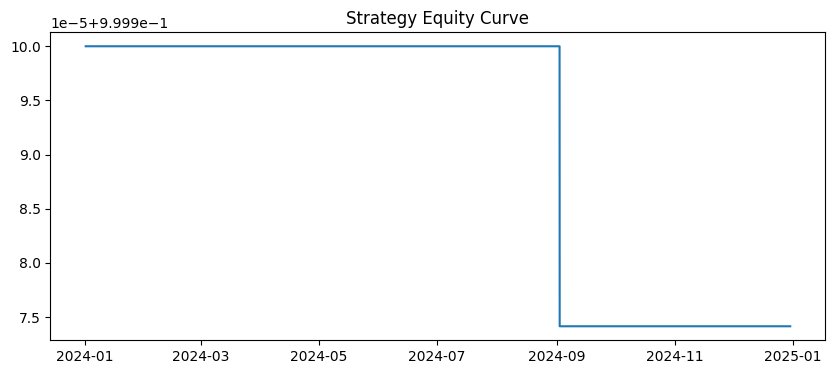

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df["datetime"], df["cum_return"])
plt.title("Strategy Equity Curve")
plt.show()


In [7]:
df.to_csv("../results/baseline_strategy_results.csv", index=False)
